# Diffusion Models for NEMO

## Setup and Imports:

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
import xarray as xr
import xbatcher
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [3]:
!nvidia-smi

Mon Apr 22 15:51:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           On  | 00000000:88:00.0 Off |                    0 |
| N/A   47C    P0              44W / 300W |      3MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## The Data


In [4]:
!ls /gpfsstore/rech/omr/uym68qx/nemo_output/DINO/Dinoffusion/1degree

Dinoffusion_1deg.out  restart36  restart38  restart40  restart42
launch_restart.sh     restart37  restart39  restart41


In [5]:
data_TS = xr.open_mfdataset('/gpfsstore/rech/omr/uym68qx/nemo_output/DINO/Dinoffusion/1degree/restart*/DINO_10d_grid_T_3D.nc')
data_TS

<xarray.Dataset> Size: 38GB
Dimensions:              (y: 199, x: 62, deptht: 36, time_counter: 10800,
                          axis_nbounds: 2)
Coordinates:
    nav_lat              (y, x) float32 49kB dask.array<chunksize=(199, 62), meta=np.ndarray>
    nav_lon              (y, x) float32 49kB dask.array<chunksize=(199, 62), meta=np.ndarray>
  * deptht               (deptht) float32 144B 5.034 15.32 ... 4.253e+03
    time_instant         (time_counter) object 86kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter         (time_counter) object 86kB 1851-01-11 00:00:00 ... 2...
Dimensions without coordinates: y, x, axis_nbounds
Data variables:
    deptht_bounds        (time_counter, deptht, axis_nbounds) float32 3MB dask.array<chunksize=(1800, 36, 2), meta=np.ndarray>
    time_instant_bounds  (time_counter, axis_nbounds) object 173kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds  (time_counter, axis_nbounds) object 173kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    toce_inst            (time_counter, deptht, y, x) float32 19GB dask.array<chunksize=(1, 36, 199, 62), meta=np.ndarray>
    soce_inst            (time_counter, deptht, y, x) float32 19GB dask.array<chunksize=(1, 36, 199, 62), meta=np.ndarray>
Attributes:
    name:         DINO_10d_grid_T_3D
    description:  ocean T grid 3D variables 10-daily
    title:        ocean T grid 3D variables 10-daily
    Conventions:  CF-1.6
    timeStamp:    2024-Apr-13 10:59:34 GMT
    uuid:         a8cb25e4-77e2-41c9-b5b3-527689d70d05

In [6]:
data_SSH = xr.open_mfdataset('/gpfsstore/rech/omr/uym68qx/nemo_output/DINO/Dinoffusion/1degree/restart*/DINO_10d_grid_T_2D.nc')
data_SSH

<xarray.Dataset> Size: 534MB
Dimensions:              (y: 199, x: 62, time_counter: 10800, axis_nbounds: 2)
Coordinates:
    nav_lat              (y, x) float32 49kB dask.array<chunksize=(199, 62), meta=np.ndarray>
    nav_lon              (y, x) float32 49kB dask.array<chunksize=(199, 62), meta=np.ndarray>
    time_instant         (time_counter) object 86kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter         (time_counter) object 86kB 1851-01-11 00:00:00 ... 2...
Dimensions without coordinates: y, x, axis_nbounds
Data variables:
    time_instant_bounds  (time_counter, axis_nbounds) object 173kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds  (time_counter, axis_nbounds) object 173kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    ssh_inst             (time_counter, y, x) float32 533MB dask.array<chunksize=(1, 199, 62), meta=np.ndarray>
Attributes:
    name:         DINO_10d_grid_T_2D
    description:  ocean T grid 2D variables 10-daily
    title:        ocean T grid 2D variables 10-daily
    Conventions:  CF-1.6
    timeStamp:    2024-Apr-13 10:59:34 GMT
    uuid:         c0126de2-2edf-4993-af15-95fcc9db846d

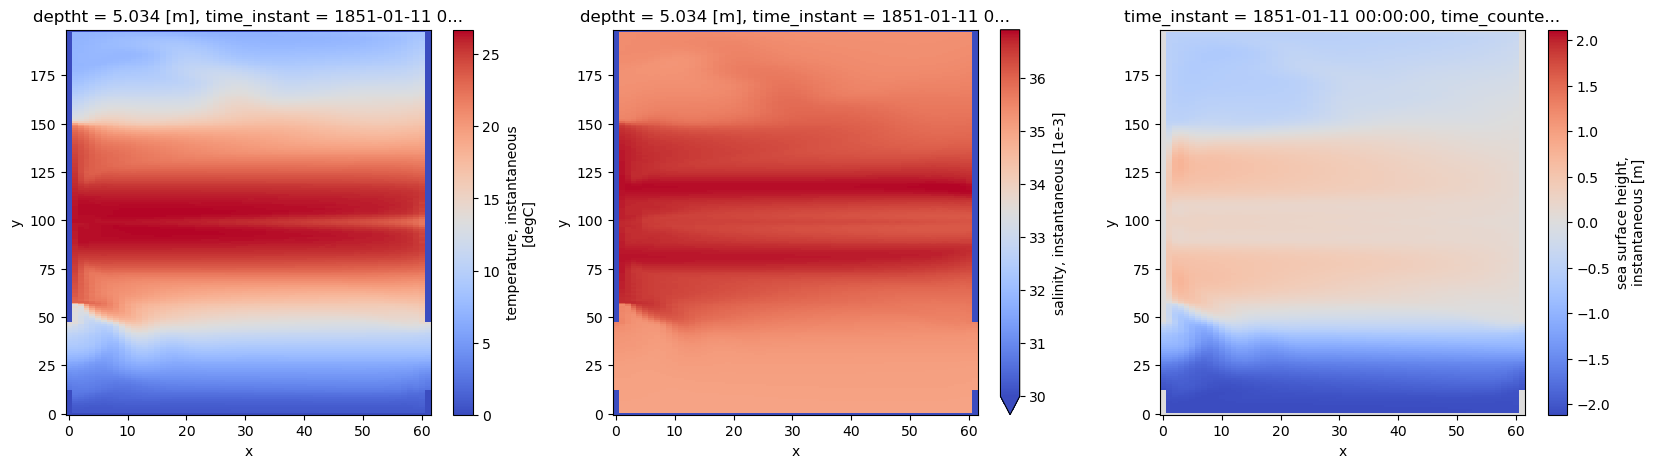

In [8]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
(data_TS.toce_inst[0,0,:,:]).plot(cmap='coolwarm')
plt.subplot(1,3,2)
(data_TS.soce_inst[0,0,:,:]).plot(vmin=30, cmap='coolwarm')
plt.subplot(1,3,3)
(data_SSH.ssh_inst[0,:,:]).plot(cmap='coolwarm')

In [19]:
data.toce_inst[:,-1,:,:].values.sum() ### first level in T always zero

0.0

In [20]:
data.soce_inst[:,-1,:,:].values.sum() ### first level in S always zero

0.0

# SSH

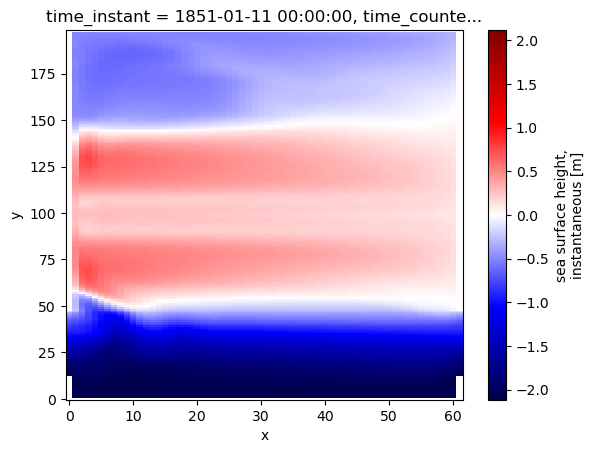

In [13]:
(data_SSH.ssh_inst[0,:,:]).plot(cmap='seismic')

In [9]:
dataset = data_SSH.ssh_inst.expand_dims(dim="channel", axis=1).values
###### added one line because Dimensions must be a multiple of 2 ** (len(block_out_channels) - 1 which is 4 here
dataset.shape

(10800, 1, 199, 62)

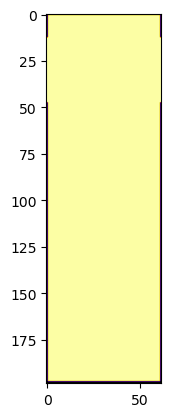

In [10]:
mask = 1. * (dataset[0,0,:,:]!=0)
plt.imshow(mask,cmap='inferno')

array([-2.12027359, -2.09140491, -2.06253624, -2.03366733, -2.00479865,
       -1.97592998, -1.94706118, -1.91819251, -1.88932371, -1.86045504,
       -1.83158624, -1.80271757, -1.77384877, -1.7449801 , -1.7161113 ,
       -1.68724263, -1.65837383, -1.62950516, -1.60063636, -1.57176769,
       -1.54289889, -1.51403022, -1.48516142, -1.45629275, -1.42742395,
       -1.39855528, -1.36968648, -1.34081781, -1.31194901, -1.28308034,
       -1.25421154, -1.22534287, -1.19647408, -1.1676054 , -1.13873661,
       -1.10986793, -1.08099914, -1.05213046, -1.02326167, -0.99439293,
       -0.9655242 , -0.93665546, -0.90778673, -0.87891799, -0.85004926,
       -0.82118052, -0.79231179, -0.76344305, -0.73457432, -0.70570558,
       -0.67683685, -0.64796817, -0.61909944, -0.5902307 , -0.56136197,
       -0.53249323, -0.5036245 , -0.47475573, -0.445887  , -0.41701826,
       -0.38814953, -0.35928079, -0.33041206, -0.30154333, -0.27267459,
       -0.24380587, -0.21493714, -0.1860684 , -0.15719967, -0.12

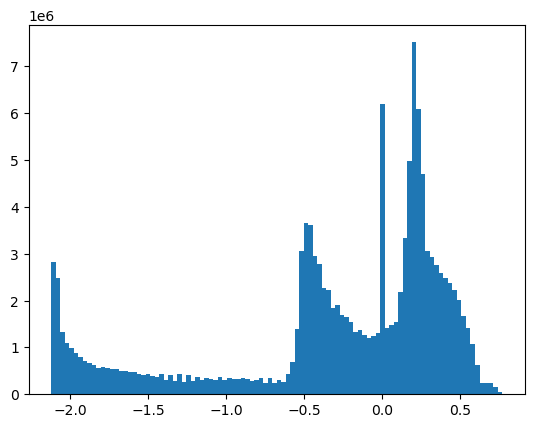

In [27]:
plt.hist(dataset.flatten(), bins=100)[1]

array([-1.        , -0.98000002, -0.95999998, -0.94      , -0.92000002,
       -0.89999998, -0.88      , -0.86000001, -0.83999997, -0.81999999,
       -0.80000001, -0.77999997, -0.75999999, -0.74000001, -0.72000003,
       -0.69999999, -0.68000001, -0.66000003, -0.63999999, -0.62      ,
       -0.60000002, -0.57999998, -0.56      , -0.54000002, -0.51999998,
       -0.5       , -0.47999999, -0.46000001, -0.44      , -0.41999999,
       -0.40000001, -0.38      , -0.36000001, -0.34      , -0.31999999,
       -0.30000001, -0.28      , -0.25999999, -0.23999999, -0.22      ,
       -0.2       , -0.18000001, -0.16      , -0.14      , -0.12      ,
       -0.1       , -0.08      , -0.06      , -0.04      , -0.02      ,
        0.        ,  0.02      ,  0.04      ,  0.06      ,  0.08      ,
        0.1       ,  0.12      ,  0.14      ,  0.16      ,  0.18000001,
        0.2       ,  0.22      ,  0.23999999,  0.25999999,  0.28      ,
        0.30000001,  0.31999999,  0.34      ,  0.36000001,  0.38

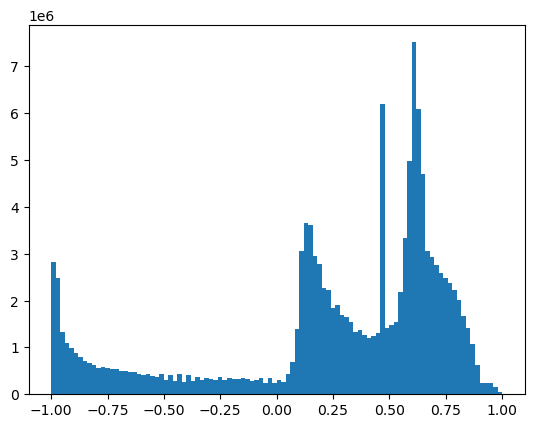

In [11]:
############ need to normalize data between -1 and 1 ############
dataset_scaled = 2 * ((dataset - dataset.min()) / (dataset.max() - dataset.min())) - 1
plt.hist(dataset_scaled.flatten(), bins=100)[1]

In [12]:
del data_SSH, dataset

# T and S

# DDPM

### The UNet

The diffusers UNet2DModel model has a number of improvements over our basic UNet above:

*   GroupNorm applies group normalization to the inputs of each block
*   Dropout layers for smoother training
*   Multiple resnet layers per block (if layers_per_block isn't set to 1)
*   Attention (usually used only at lower resolution blocks)
*   Conditioning on the timestep.
*   Downsampling and upsampling blocks with learnable parameters

Let's create and inspect a UNet2DModel:



In [13]:
# Dataloader (you can mess with batch size)
batch_size = 16
train_dataloader = DataLoader(dataset_scaled, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Create the network
net = UNet2DModel(
    sample_size=[200, 64],  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(net.parameters(), lr=3e-4)

In [16]:
losses = []

for epoch in range(n_epochs):
    for batch in train_dataloader:
        clean_images = batch.to(device)
        mask_tensor = torch.from_numpy(mask).expand(clean_images.shape).type(torch.float).to(device)
        
        ### pad one line at the bottom to make size number of lines 200 a multiple of 4
        clean_images = F.pad(clean_images, (1, 1, 0, 1), "constant", 0)
        mask_tensor = F.pad(mask_tensor, (1, 1, 0, 1), "constant", 0)
        
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bs,), device=device).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = net(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = loss_fn(mask_tensor * noise_pred, mask_tensor * noise)
        loss.backward()
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 1 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")


Epoch:1, loss: 0.0014685466730346283
Epoch:2, loss: 0.0013629481101115407


KeyboardInterrupt: 

/tmp/ipykernel_1897289/1692867827.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[0].set_ylim(0, 0.1)


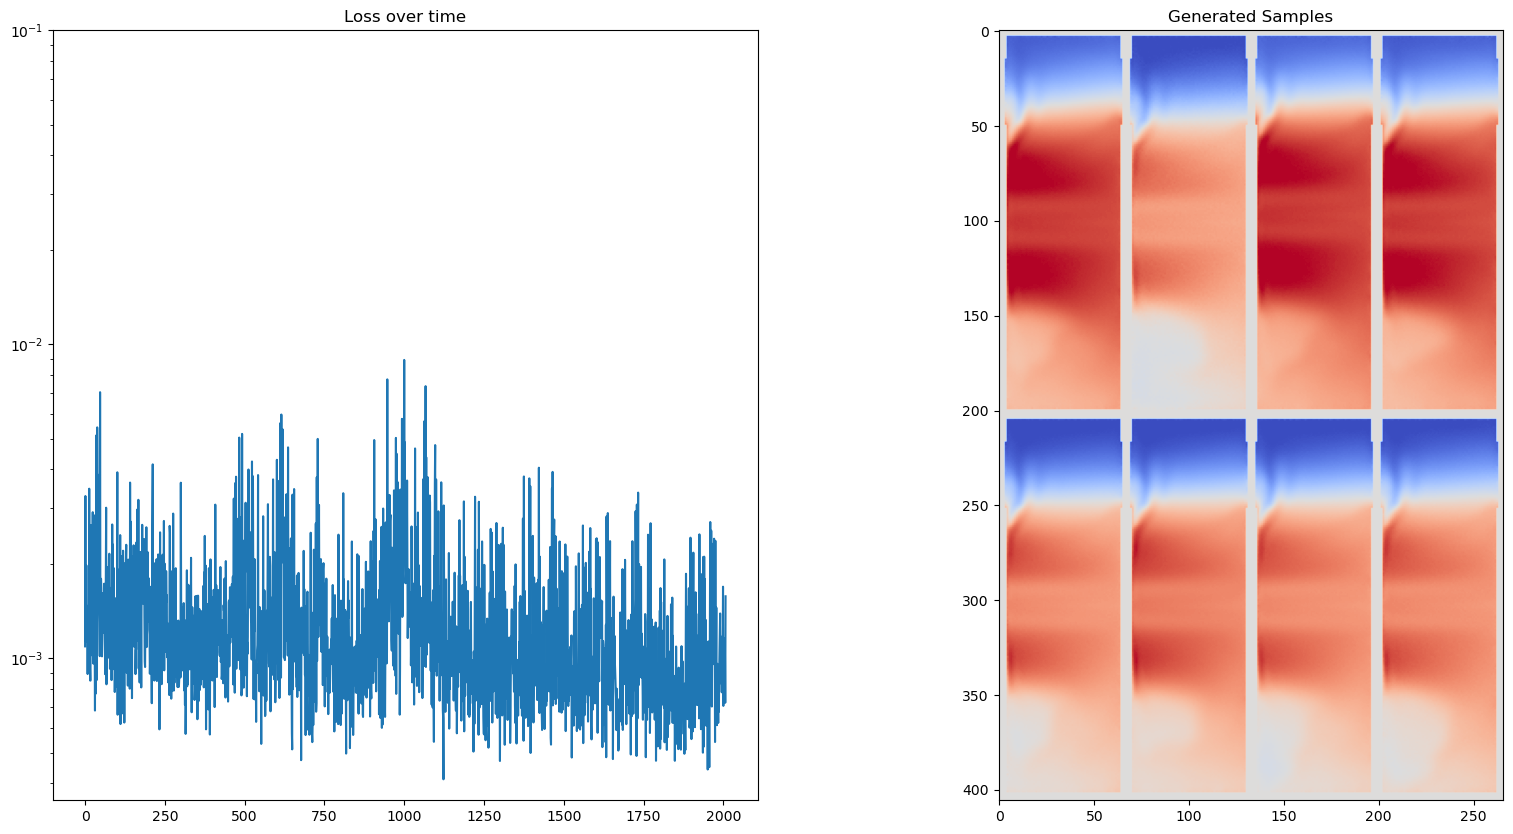

In [29]:
# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Losses
axs[0].semilogy(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

# Samples
sample = torch.randn(8, 1, 199, 62).to(device)
mask_tensor = torch.from_numpy(mask).expand(sample.shape).type(torch.float).to(device)

sample = F.pad(sample, (1, 1, 0, 1), "constant", 0)
mask_tensor = F.pad(mask_tensor, (1, 1, 0, 1), "constant", 0)

for i, t in enumerate(noise_scheduler.timesteps):
    # Get model pred
    with torch.no_grad():
        residual = net(sample, t).sample
    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

sample = mask_tensor * sample

axs[1].imshow(make_grid(sample.detach().cpu(), nrow=4)[0], cmap='coolwarm')
axs[1].set_title('Generated Samples');